# Stacked Thermodynamic Profiles (Spline Smoothing)

In [1]:
#PART 1: Loadiing Packages

import yt
import pyxsim

import h5py
import numpy as np
import illustris_python as il
import glob
from numba import jit

from tqdm import tqdm
import os
import pylab as plt
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor

soxs : [WARNING  ] 2025-05-16 19:00:41,597 Setting 'soxs_data_dir' to /home/tnguser/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [2]:
#PART 2: Simulation Specification
basePath = "../../../sims.TNG/TNG100-1/output/"
snap = 50                                                       #z=1
nbins = 15
r_norm_max = 2
max_workers = 3
tag = ["Efficient_AGN", "Efficient_Non", "Inefficient_AGN", "Inefficient_Non"]
hm = "6"

In [15]:
def process_single_halo(haloID, label):
    try:
        print(f"Processing {label} halo {haloID}...")
        halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

        header = il.groupcat.loadHeader(basePath, snap)
        gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas")
        with h5py.File(il.snapshot.snapPath(basePath, snap), 'r') as f:
            header_snap = dict(f['Header'].attrs)

        filename = f"halo_{label}_{haloID}.hdf5"
        with h5py.File(filename, 'w') as f:
            for key in gas.keys():
                f['PartType0/' + key] = gas[key]
            f.create_group('Header')
            f['Header'].attrs['NumFilesPerSnapshot'] = 1
            f['Header'].attrs['MassTable'] = header_snap['MassTable']
            f['Header'].attrs['BoxSize'] = header['BoxSize']
            f['Header'].attrs['Time'] = header['Time']
            f['Header'].attrs['Redshift'] = header['Redshift']
            f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
            f['Header'].attrs['HubbleParam'] = header['HubbleParam']
            f['Header'].attrs['Omega0'] = header['Omega0']
            f['Header'].attrs['OmegaLambda'] = header['OmegaLambda']
            f['Header'].attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
            f['Header'].attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
            f['Header'].attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

        ds = yt.load(filename)

        c = ds.arr(halo["GroupPos"], "code_length").to("kpc")
        r200a = ds.arr(halo["Group_R_Crit200"], "code_length").to("kpc")
        r200 = r200a.to_value("kpc") 
        del halo, header, gas

        sp = ds.sphere(c, r_norm_max * r200)
        radii = np.linalg.norm(sp["PartType0", "Coordinates"].to("kpc") - c, axis=1) / r200
        hsml = ds.arr(sp["PartType0", "SubfindHsml"], "code_length").to("kpc")/ r200

        #r_bins = np.linspace(0, r_norm_max, nbins + 1)
        r_bins = np.logspace(np.log10(1e-3), np.log10(r_norm_max), nbins + 1)
        
        @jit(nopython=True)
        def W_B2(r, h):
            q = r / h
            W = np.zeros_like(r)
            factor = ( 7.0 * np.pi )/ (8 * h**3)

            mask1 = (q >= 0) & (q < 0.5)
            mask2 = (q >= 0.5) & (q < 1.0)

            W[mask1] = factor[mask1] * (1 - 6*q[mask1]**2 + 6*q[mask1]**3)
            W[mask2] = factor[mask2] * (2 * (1 - q[mask2])**3)
            return W

        def sph_smooth_b2(radii, values, hsml, r_bins):    

            #r_bin_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
            r_bin_centers = np.sqrt(r_bins[:-1] * r_bins[1:])

            smoothed = np.zeros(len(r_bin_centers))
            weights = np.zeros(len(r_bin_centers))

            for i, r_center in enumerate(r_bin_centers):
                dr = np.abs(radii - r_center)  # Distances to all particles
                mask = dr < hsml
                if np.any(mask):
                    w = W_B2(dr[mask], hsml[mask])
                    smoothed[i] = np.sum(values[mask] * w)
                    weights[i] = np.sum(w)
            smoothed = np.divide(smoothed, weights, out=np.zeros_like(smoothed), where=weights > 0)    
            return smoothed
      
        temp     = sph_smooth_b2(radii, sp["gas", "temperature"].to("K").value, hsml, r_bins)
        entropy  = sph_smooth_b2(radii, sp["gas", "entropy"].to("keV*cm**2").value, hsml, r_bins)
        pressure = sph_smooth_b2(radii, sp["gas", "pressure"].to("dyne/cm**2").value, hsml, r_bins)
        density  = sph_smooth_b2(radii, sp["gas", "density"].to("g/cm**3").value, hsml, r_bins)
        ne       = sph_smooth_b2(radii, sp["gas", "El_number_density"].to("1/cm**3").value, hsml, r_bins)
        sfr      = sph_smooth_b2(radii, sp["gas", "star_formation_rate"].to("g/s").value, hsml, r_bins)
        metal    = sph_smooth_b2(radii, sp["gas", "metallicity"].value, hsml, r_bins)


        for f in [filename, filename + ".ewah"]:
            if os.path.exists(f):
                os.remove(f)

        return temp, entropy, pressure, density, ne, sfr, metal

    except Exception as e:
        print(f"❌ Failed for halo {haloID}: {e}")
        return None

def combined_profiles(halo_list, label):
    temp_all = []
    entropy_all = []
    pressure_all = []
    density_all = []
    ne_all = []
    sfr_all = []
    metal_all = []
                            
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
    #with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single_halo, haloID, label): haloID for haloID in halo_list}
        with tqdm(total=len(futures), desc=f"Processing {label} halos") as pbar:
            for future in as_completed(futures):
                result = future.result()
                if result:
                    t, e, p, d, n, s, m = result
                    temp_all.append(t)
                    entropy_all.append(e)
                    pressure_all.append(p)
                    density_all.append(d)
                    ne_all.append(n)
                    sfr_all.append(s)
                    metal_all.append(m)
                pbar.update(1)


    np.savez(f"combined100_hm{hm}_{label}.npz",
             temperature_mean=np.nanmean(temp_all, axis=0),
             temperature_sem=np.nanstd(temp_all, axis=0, ddof=1) / np.sqrt(len(temp_all)),
             entropy_mean=np.nanmean(entropy_all, axis=0),
             entropy_sem=np.nanstd(entropy_all, axis=0, ddof=1) / np.sqrt(len(entropy_all)),
             pressure_mean=np.nanmean(pressure_all, axis=0),
             pressure_sem=np.nanstd(pressure_all, axis=0, ddof=1) / np.sqrt(len(pressure_all)),
             density_mean=np.nanmean(density_all, axis=0),
             density_sem=np.nanstd(density_all, axis=0, ddof=1) / np.sqrt(len(density_all)),
             ne_mean=np.nanmean(ne_all, axis=0),
             ne_sem=np.nanstd(ne_all, axis=0, ddof=1) / np.sqrt(len(ne_all)),
             sfr_mean=np.nanmean(sfr_all, axis=0),
             sfr_sem=np.nanstd(sfr_all, axis=0, ddof=1) / np.sqrt(len(sfr_all)),
             metal_mean=np.nanmean(metal_all, axis=0),
             metal_sem=np.nanstd(metal_all, axis=0, ddof=1) / np.sqrt(len(metal_all)))

    print(f"✅ Saved combined100_hm{hm}_{label}.npz")


In [16]:
#PART 4B:: Usage: Calculate avg and std of mean of all halo profiles of same halo labels and save in 4 different npz

data = np.load(f"accretor_agn100_hm{hm}.npz")

combined_profiles(data["ha_agn"], tag[0])
combined_profiles(data["hn_agn"], tag[2])
combined_profiles(data["hn_non"], tag[3])
'''

data1 = np.load(f"accretor_agn100_hm1.npz")
data2 = np.load(f"accretor_agn100_hm2.npz")
data3 = np.load(f"accretor_agn100_hm3.npz")
data4 = np.load(f"accretor_agn100_hm4.npz")
data5 = np.load(f"accretor_agn100_hm5.npz")
data6 = np.load(f"accretor_agn100_hm6.npz")

combined_profiles(data1["ha_agn"], tag[0], "1")
combined_profiles(data1["hn_agn"], tag[2], "1")
combined_profiles(data1["hn_non"], tag[3], "1")

combined_profiles(data2["ha_agn"], tag[0], "2")
combined_profiles(data2["hn_agn"], tag[2], "2")
combined_profiles(data2["hn_non"], tag[3], "2")

combined_profiles(data3["ha_agn"], tag[0], "3")
combined_profiles(data3["hn_agn"], tag[2], "3")
combined_profiles(data3["hn_non"], tag[3], "3")

combined_profiles(data4["ha_agn"], tag[0], "4")
combined_profiles(data4["hn_agn"], tag[2], "4")
combined_profiles(data4["hn_non"], tag[3], "4")

combined_profiles(data5["ha_agn"], tag[0], "5")
combined_profiles(data5["hn_agn"], tag[2], "5")
combined_profiles(data5["hn_non"], tag[3], "5")

combined_profiles(data6["ha_agn"], tag[0], "6")
combined_profiles(data6["hn_agn"], tag[2], "6")
combined_profiles(data6["hn_non"], tag[3], "6")
'''

Processing Efficient_AGN halos: 0it [00:00, ?it/s]

✅ Saved combined100_hm6_Efficient_AGN.npz



/tmp/ipykernel_768/1595637655.py:121: RuntimeWarning: Mean of empty slice
  temperature_mean=np.nanmean(temp_all, axis=0),
/tmp/ipykernel_768/1595637655.py:123: RuntimeWarning: Mean of empty slice
  entropy_mean=np.nanmean(entropy_all, axis=0),
/tmp/ipykernel_768/1595637655.py:125: RuntimeWarning: Mean of empty slice
  pressure_mean=np.nanmean(pressure_all, axis=0),
/tmp/ipykernel_768/1595637655.py:127: RuntimeWarning: Mean of empty slice
  density_mean=np.nanmean(density_all, axis=0),
/tmp/ipykernel_768/1595637655.py:129: RuntimeWarning: Mean of empty slice
  ne_mean=np.nanmean(ne_all, axis=0),
/tmp/ipykernel_768/1595637655.py:131: RuntimeWarning: Mean of empty slice
  sfr_mean=np.nanmean(sfr_all, axis=0),
/tmp/ipykernel_768/1595637655.py:133: RuntimeWarning: Mean of empty slice
  metal_mean=np.nanmean(metal_all, axis=0),
Processing Inefficient_AGN halos:   0%|          | 0/10 [00:00<?, ?it/s]

Processing Inefficient_AGN halo 0...Processing Inefficient_AGN halo 3...
Processing Inefficient_AGN halo 1...



yt : [INFO     ] 2025-05-16 16:50:24,190 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-16 16:50:24,311 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-16 16:50:24,312 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-16 16:50:24,314 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-16 16:50:24,316 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-16 16:50:24,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-16 16:50:24,318 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-16 16:50:24,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-16 16:50:24,320 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-16 16:50:24,321 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-16 16:50:24,322 Parameters: hubble_consta

Processing Inefficient_AGN halo 4...


yt : [INFO     ] 2025-05-16 16:51:16,391 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-16 16:51:16,493 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-16 16:51:16,494 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-16 16:51:16,496 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-16 16:51:16,498 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-16 16:51:16,500 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-16 16:51:16,501 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-16 16:51:16,505 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-16 16:51:16,507 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-16 16:51:16,508 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-16 16:51:16,509 Parameters: hubble_consta

Processing Inefficient_AGN halo 5...


Processing Inefficient_AGN halos:  30%|███       | 3/10 [01:17<02:25, 20.79s/it]

Processing Inefficient_AGN halo 6...


yt : [INFO     ] 2025-05-16 16:51:32,255 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-16 16:51:32,345 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-16 16:51:32,347 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-16 16:51:32,348 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-16 16:51:32,349 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-16 16:51:32,351 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-16 16:51:32,353 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-16 16:51:32,354 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-16 16:51:32,356 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-16 16:51:32,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-16 16:51:32,358 Parameters: hubble_consta

Processing Inefficient_AGN halo 9...


yt : [INFO     ] 2025-05-16 16:52:02,626 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-16 16:52:02,709 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-16 16:52:02,710 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-16 16:52:02,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-16 16:52:02,712 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-16 16:52:02,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-16 16:52:02,716 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-16 16:52:02,718 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-16 16:52:02,720 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-16 16:52:02,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-16 16:52:02,723 Parameters: hubble_consta

Processing Inefficient_AGN halo 11...


Processing Inefficient_AGN halos:  60%|██████    | 6/10 [01:57<00:54, 13.73s/it]

Processing Inefficient_AGN halo 12...


Initializing refined index: 100%|██████████| 22/22 [00:09<00:00,  2.42it/s]
yt : [INFO     ] 2025-05-16 16:52:14,683 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-16 16:52:14,759 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-16 16:52:14,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-16 16:52:14,762 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-16 16:52:14,764 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-16 16:52:14,766 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-16 16:52:14,767 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-16 16:52:14,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-16 16:52:14,769 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-16 16:52:14,770 Parameters: omega_radiation       

Processing Inefficient_AGN halo 14...


yt : [INFO     ] 2025-05-16 16:52:36,829 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-16 16:52:36,903 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-16 16:52:36,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-16 16:52:36,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-16 16:52:36,907 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-16 16:52:36,909 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-16 16:52:36,911 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-16 16:52:36,911 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-16 16:52:36,912 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-16 16:52:36,914 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-16 16:52:36,915 Parameters: hubble_consta

✅ Saved combined100_hm6_Inefficient_AGN.npz



Processing Inefficient_Non halos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Inefficient_Non halo 2...Processing Inefficient_Non halo 8...

Processing Inefficient_Non halo 7...


yt : [INFO     ] 2025-05-16 16:53:02,933 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-16 16:53:03,051 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-16 16:53:03,052 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-16 16:53:03,053 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-16 16:53:03,055 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-16 16:53:03,057 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-16 16:53:03,059 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-16 16:53:03,061 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-16 16:53:03,062 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-16 16:53:03,064 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-16 16:53:03,065 Parameters: hubble_consta

Processing Inefficient_Non halo 10...

Processing Inefficient_Non halos:  25%|██▌       | 1/4 [00:39<01:57, 39.27s/it]

Processing Inefficient_Non halos:  50%|█████     | 2/4 [00:39<00:32, 16.47s/it]yt : [INFO     ] 2025-05-16 16:53:40,483 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-16 16:53:40,572 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-16 16:53:40,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-16 16:53:40,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-16 16:53:40,578 Parameters: domain_right_edge         = [75000. 75000. 75000.]
yt : [INFO     ] 2025-05-16 16:53:40,580 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-16 16:53:40,581 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-16 16:53:40,585 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-16 16:53:40,586 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-16 16:53:40,588 Parameters: omega_radiation    

✅ Saved combined100_hm6_Inefficient_Non.npz


'\n\ndata1 = np.load(f"accretor_agn100_hm1.npz")\ndata2 = np.load(f"accretor_agn100_hm2.npz")\ndata3 = np.load(f"accretor_agn100_hm3.npz")\ndata4 = np.load(f"accretor_agn100_hm4.npz")\ndata5 = np.load(f"accretor_agn100_hm5.npz")\ndata6 = np.load(f"accretor_agn100_hm6.npz")\n\ncombined_profiles(data1["ha_agn"], tag[0], "1")\ncombined_profiles(data1["hn_agn"], tag[2], "1")\ncombined_profiles(data1["hn_non"], tag[3], "1")\n\ncombined_profiles(data2["ha_agn"], tag[0], "2")\ncombined_profiles(data2["hn_agn"], tag[2], "2")\ncombined_profiles(data2["hn_non"], tag[3], "2")\n\ncombined_profiles(data3["ha_agn"], tag[0], "3")\ncombined_profiles(data3["hn_agn"], tag[2], "3")\ncombined_profiles(data3["hn_non"], tag[3], "3")\n\ncombined_profiles(data4["ha_agn"], tag[0], "4")\ncombined_profiles(data4["hn_agn"], tag[2], "4")\ncombined_profiles(data4["hn_non"], tag[3], "4")\n\ncombined_profiles(data5["ha_agn"], tag[0], "5")\ncombined_profiles(data5["hn_agn"], tag[2], "5")\ncombined_profiles(data5["hn_n

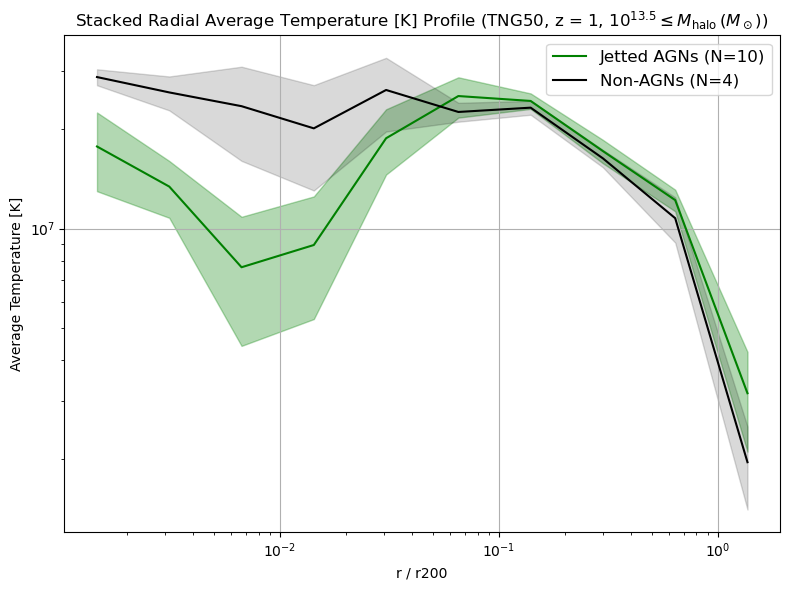

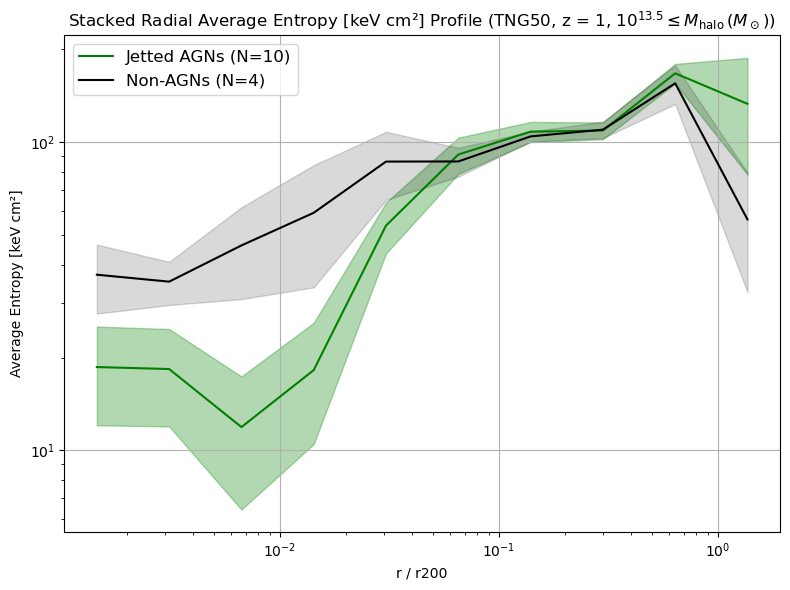

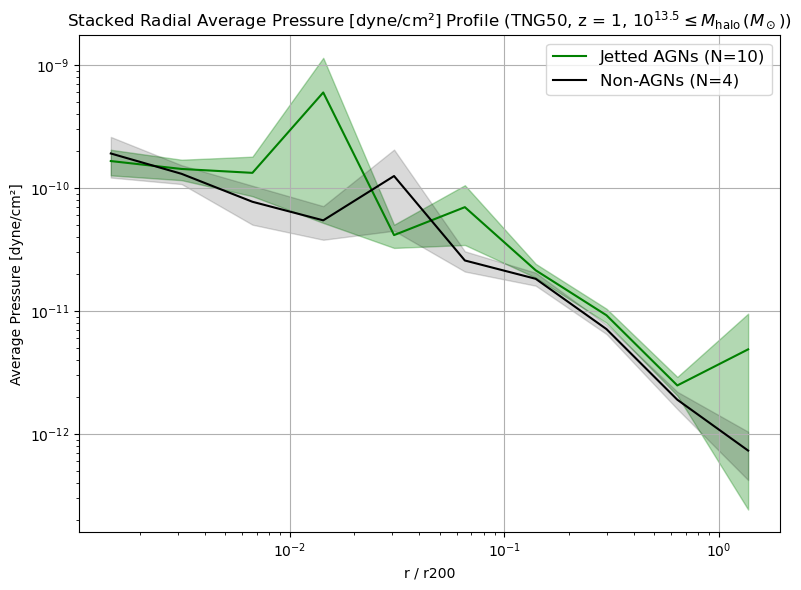

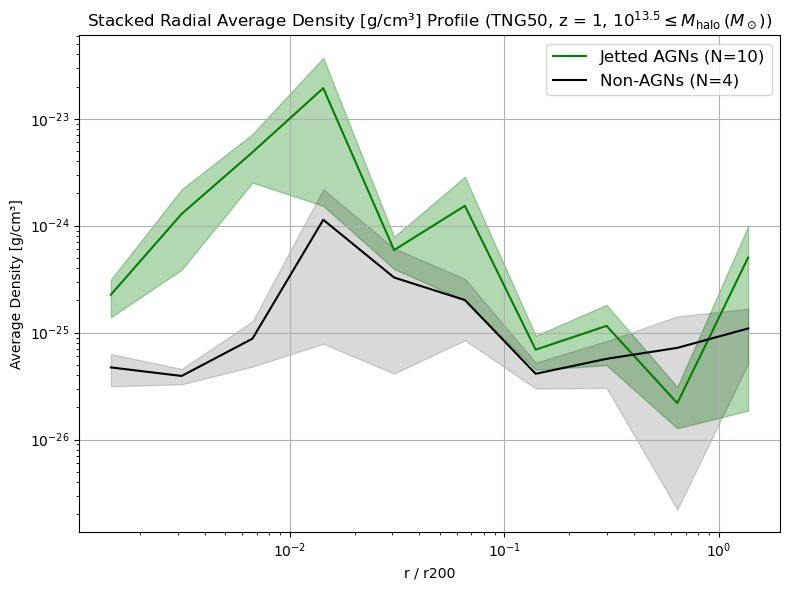

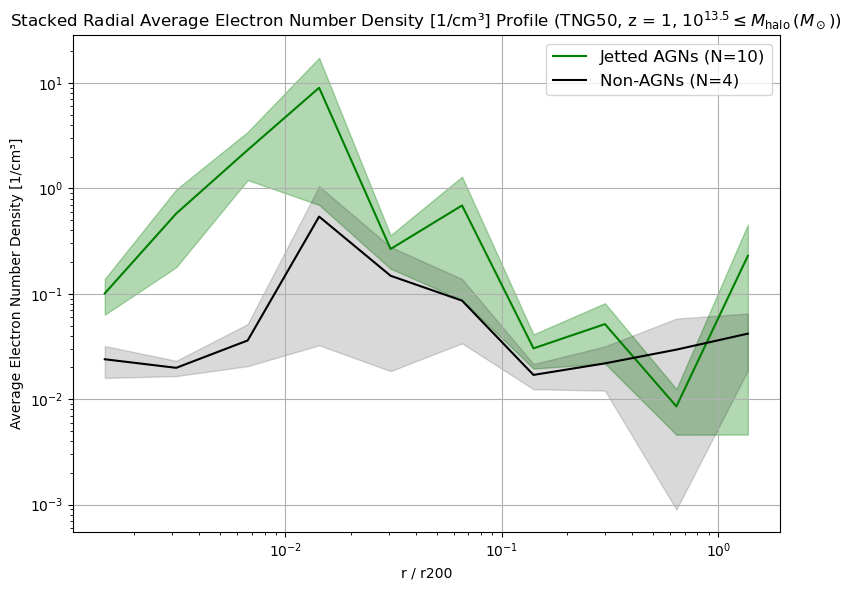

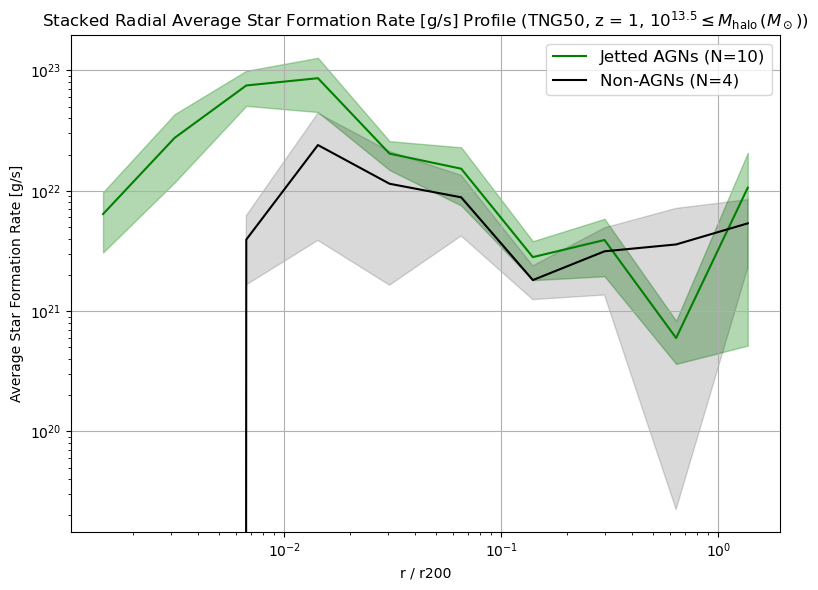

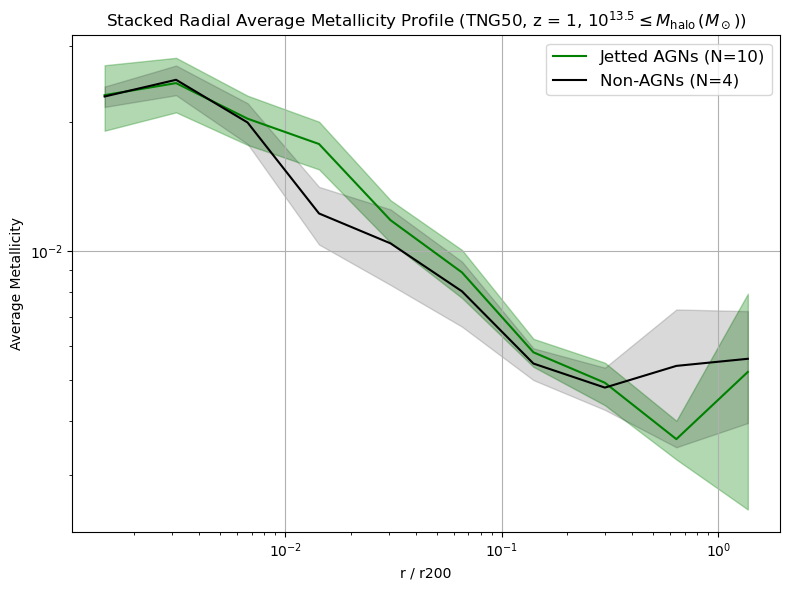

In [13]:
# PART 5: Plot Thermodynamical Profiles (with 3 labels in each)

#bin_edges = np.linspace(0, r_norm_max, nbins + 1)
#bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

bin_edges = np.logspace(np.log10(1e-3), np.log10(r_norm_max), nbins + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

#hm = "6"
hmn = r"$10^{13.5} \leq M_{\rm halo} \, (M_\odot)$"

hmv = ["1", "2", "3", "4", "5", "6"]

hmname = [
    r"$10^{11} \leq M_{\rm halo} < 10^{11.5} \, M_\odot$",
    r"$10^{11.5} \leq M_{\rm halo} < 10^{12} \, M_\odot$",
    r"$10^{12} \leq M_{\rm halo} < 10^{12.5} \, M_\odot$",
    r"$10^{12.5} \leq M_{\rm halo} < 10^{13} \, M_\odot$",
    r"$10^{13} \leq M_{\rm halo} < 10^{13.5} \, M_\odot$",
    r"$10^{13.5} \leq M_{\rm halo} \, (M_\odot)$"
]

#for hm, hmn in zip(hmv, hmname):
#profiles_ha_agn = np.load(f"combined100_hm{hm}_{tag[0]}.npz")
profiles_hn_agn = np.load(f"combined100_hm{hm}_{tag[2]}.npz")
profiles_hn_non = np.load(f"combined100_hm{hm}_{tag[3]}.npz")

hm_labels = [
    r"$10^{11} - 10^{11.5} \, M_\odot$",
    r"$10^{11.5} - 10^{12} \, M_\odot$",
    r"$10^{12} - 10^{12.5} \, M_\odot$",
    r"$10^{12.5} - 10^{13} \, M_\odot$",
    r"$10^{13} - 10^{13.5} \, M_\odot$",
    r"$> 10^{13.5} \, M_\odot$"
]

data = np.load(f"accretor_agn100_hm{hm}.npz")          #ha_agn, ha_non, hn_agn, hn_non ids
#ha_agn = data["ha_agn"]
hn_agn = data["hn_agn"]
hn_non = data["hn_non"]

def plot_quantity(quantity, ylabel, filename):

    #avg_ha_agn = profiles_ha_agn[f"{quantity}_mean"]
    #err_ha_agn = profiles_ha_agn[f"{quantity}_sem"]

    avg_hn_agn = profiles_hn_agn[f"{quantity}_mean"]
    err_hn_agn = profiles_hn_agn[f"{quantity}_sem"]

    avg_hn_non = profiles_hn_non[f"{quantity}_mean"]
    err_hn_non = profiles_hn_non[f"{quantity}_sem"]

    plt.figure(figsize=(8, 6))

    # Efficient Accretors - AGN
    #plt.plot(bin_centers, avg_ha_agn.flatten(), label=f"Radiative AGNs (N={len(ha_agn)})", color="red")
    #plt.fill_between(bin_centers, (avg_ha_agn - err_ha_agn).flatten(), (avg_ha_agn + err_ha_agn).flatten(),
     #                color="red", alpha=0.3)


    # Inefficient Accretors - AGN
    plt.plot(bin_centers, avg_hn_agn.flatten(), label=f"Jetted AGNs (N={len(hn_agn)})", color="green")
    plt.fill_between(bin_centers, (avg_hn_agn - err_hn_agn).flatten(), (avg_hn_agn + err_hn_agn).flatten(),
                     color="green", alpha=0.3)

    # Inefficient Accretors - Non-AGN
    plt.plot(bin_centers, avg_hn_non.flatten(), label=f"Non-AGNs (N={len(hn_non)})", color="black")
    plt.fill_between(bin_centers, (avg_hn_non - err_hn_non).flatten(), (avg_hn_non + err_hn_non).flatten(),
                     color="black", alpha=0.15)

    plt.xlabel("r / r200")
    plt.ylabel(ylabel)
    plt.title(f"Stacked Radial {ylabel} Profile (TNG50, z = 1, {hmn})")
    plt.legend(fontsize=12)
    plt.grid(True)
    #plt.xlim(1, 2)
    #plt.ylim(ylim)
    plt.xscale("log")
    plt.yscale("log")
    plt.tight_layout()
    #plt.savefig(filename, dpi=900)
    plt.show()

# Call the plot function for each physical quantity
plot_quantity("temperature", "Average Temperature [K]", f"temperature100_{hm}.png")
plot_quantity("entropy", "Average Entropy [keV cm²]", f"entropy100_{hm}.png")
plot_quantity("pressure", "Average Pressure [dyne/cm²]", f"pressure100_{hm}.png")
plot_quantity("density", "Average Density [g/cm³]", f"density100_{hm}.png")
plot_quantity("ne", "Average Electron Number Density [1/cm³]", f"ne100_{hm}.png")
plot_quantity("sfr", "Average Star Formation Rate [g/s]", f"sfr100_{hm}.png")
plot_quantity("metal", "Average Metallicity", f"metal100_{hm}.png")

puchii


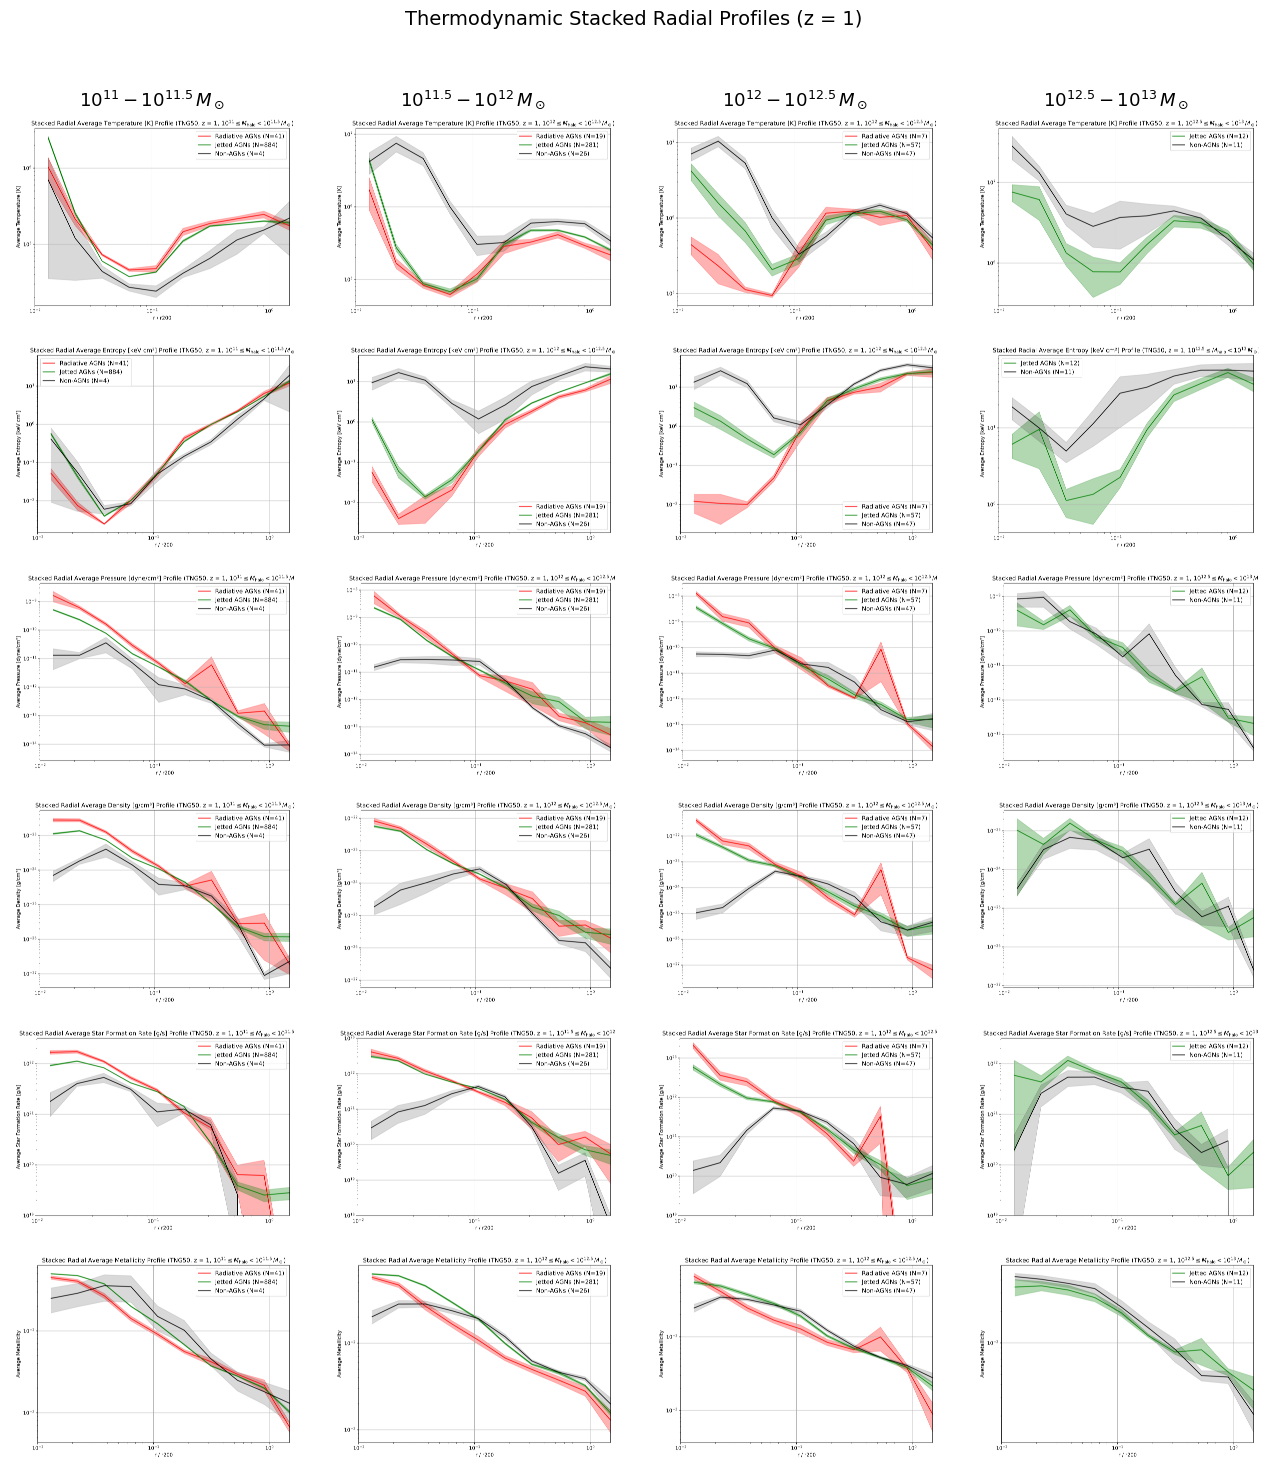

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("puchii")

quantities = ["temperature", "entropy", "pressure", "density", "ne", "sfr", "metal"]
hms = ["1", "2", "3", "4", "5", "6"]
hm_labels = [
    r"$10^{11} - 10^{11.5} \, M_\odot$",
    r"$10^{11.5} - 10^{12} \, M_\odot$",
    r"$10^{12} - 10^{12.5} \, M_\odot$",
    r"$10^{12.5} - 10^{13} \, M_\odot$",
    r"$10^{13} - 10^{13.5} \, M_\odot$",
    r"$> 10^{13.5} \, M_\odot$"
]


fig, axes = plt.subplots(len(quantities), len(hms), figsize=(15, 17))

for i, quantity in enumerate(quantities):
    for j, hm in enumerate(hms):
        filename = f"{quantity}100_{hm}.png"
        try:
            img = Image.open(filename)
            ax = axes[i, j]
            ax.imshow(np.asarray(img))
            ax.axis('off')
            if i == 0:
                ax.set_title(hm_labels[j], fontsize=13)
            if j == 0:
                ax.set_ylabel(quantity.capitalize(), fontsize=10)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            axes[i, j].axis('off')

# Add a super title
fig.suptitle("Thermodynamic Stacked Radial Profiles (TNG100-1, z = 1)", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for supertitle
plt.savefig("tng100_spline.pdf", dpi=1200)

plt.show()
